In [1]:
import numpy as np
from astropy.io import fits
from astropy.nddata import Cutout2D
import matplotlib.pyplot as plt
from lbcred.model import imfit
import pymfit, os
from collections import OrderedDict

def make_cutout(original_img_fn, position, shape, ext = 0, cutout_fn=None):
    img = fits.open(original_img_fn)
    cutout = Cutout2D(img[ext].data, position, shape)
    img[ext].data = cutout.data
    if cutout_fn is not None:
        img.writeto(cutout_fn, overwrite=True)
    img.close()
    return cutout

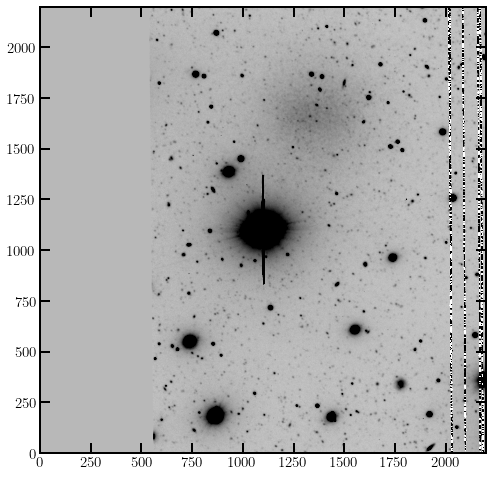

In [68]:
out_dir = '/Users/kirstencasey/real_image_tests/background_subtraction_tests/star_subtraction_tests'
stack_fn_r = os.path.join(out_dir,'mean_stack_polynomial_background_r.fits')
stack_fn_b = os.path.join(out_dir,'mean_stack_polynomial_background_b.fits')

star_r = make_cutout(stack_fn_r,(1271,2198),(2201,2201),cutout_fn=stack_fn_r.replace('_r.fits','_cutout_r.fits'))
star_b = make_cutout(stack_fn_b,(1271,2198),(2201,2201),cutout_fn=stack_fn_b.replace('_b.fits','_cutout_b.fits'))
var = fits.PrimaryHDU(np.zeros((2201,2201))+1)
var.writeto(os.path.join(out_dir,'flat_variance_image.fits'),overwrite=True)

vmin,vmax =  np.nanpercentile(star_b.data, [.5, 98.])
plt.figure(figsize=(8,10))
plt.imshow(star_b.data,vmin=vmin,vmax=vmax,cmap='gray_r',origin='lower')

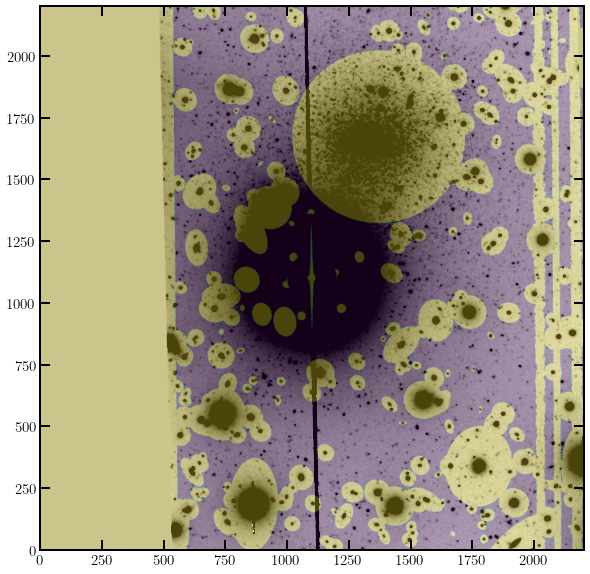

In [99]:
# Make mask for everything except star

mask_kws = dict(out_fn=os.path.join(out_dir,'star_mask_b.fits'), thresh=8.0, kern_sig=1.0, backsize=15,
                        obj_rmin=200, grow_obj=15., use_hsc_mask=False, gal_pos=(1100,1100), seg_rmin=0.)
saturation_limit = 40000.
mask = pymfit.make_mask(stack_fn_b.replace('_b.fits','_cutout_b.fits'), **mask_kws)
mask[np.where(star_b.data==0.)]=1

# Mask Blobby
r_circ = 350
i_c, j_c = (1672, 1370)
ii, jj = np.mgrid[:mask.shape[0], :mask.shape[1]]
circ_mask = ((ii - i_c)**2 + (jj - j_c)**2) - r_circ**2 < 0
mask = mask.astype(bool) | circ_mask
mask = mask.astype(float)
# Mask other stuff
r_circ = 60
i_c, j_c = (832, 539)
ii, jj = np.mgrid[:mask.shape[0], :mask.shape[1]]
circ_mask = ((ii - i_c)**2 + (jj - j_c)**2) - r_circ**2 < 0
mask = mask.astype(bool) | circ_mask
mask = mask.astype(float)

# Anti-mask star
r_circ = 100
i_c, j_c = (1100, 1100)
ii, jj = np.mgrid[:mask.shape[0], :mask.shape[1]]
star_mask = ((ii - i_c)**2 + (jj - j_c)**2) - r_circ**2 < 0
mask[star_mask] = 0

mask[800:1360,1075:1130]=0
mask[np.where(star_b.data>saturation_limit)]=1

plt.figure(figsize=(12,10))
plt.imshow(star_r.data,vmin=vmin,vmax=vmax,cmap='gray_r',origin='lower')
plt.imshow(mask,origin='lower',alpha=0.3)

In [105]:
mask_hdu = fits.PrimaryHDU(mask)
mask_hdu.writeto(os.path.join(out_dir,'star_mask.fits'),overwrite=True)

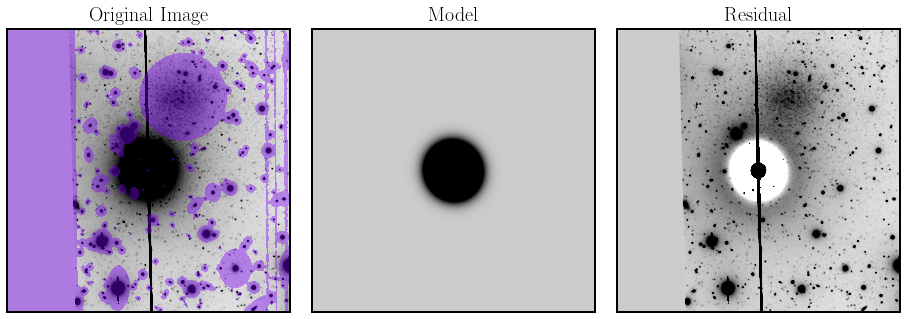

In [104]:
gauss_params = OrderedDict([
    ('PA', [20., 0., 360]),
    ('ell', [0.05, 0., 0.5]),
    ('I_0', [1000.0, 50, 2000]),
    ('sigma', [100, 0.1, 1000])
])



#model = pymfit.Model(funcs = ['Gaussian'], params = [gauss_params], centers = [[1100,1100]], dcent=40)
model = pymfit.Model(funcs = ['Gaussian','Gaussian','Gaussian','Gaussian','Gaussian','Gaussian'], params = [gauss_params,gauss_params,gauss_params,gauss_params,gauss_params,gauss_params], centers = [[1100,1100],[1100,1100],[1100,1100],[1100,1100],[1100,1100],[1100,1100]], dcent=40)
fitter = pymfit.PymFitter(model,save_files=True)
bestfit_fn = os.path.join(out_dir,'star_bestfit_r.txt')
config_fn = os.path.join(out_dir,'star_config_r.txt')

fitter.run(stack_fn_r.replace('_r.fits','_cutout_r.fits'), var_fn=os.path.join(out_dir,'flat_variance_image.fits'), mask_fn=os.path.join(out_dir,'star_mask.fits'), psf_fn=os.path.join(out_dir,'lbcr.median_psf_298.fits'), out_fn=bestfit_fn, outdir=out_dir, config_fn=config_fn, save_model=True, save_residual=True, will_viz=True)

fitter.viz_results(show=True, save_fn=os.path.join(out_dir,'star_modeling_results.png'), dpi=200);

In [103]:
fitter.results

OrderedDict([('comp_1',
              {'function': 'Gaussian',
               'X0': 1100.0,
               'Y0': 1100.0,
               'X0_err': 0.0004,
               'Y0_err': 0.0004,
               'PA': 20.0,
               'PA_err': 0.0034674,
               'ell': 0.05,
               'ell_err': 35277000.0,
               'I_0': 2000.0,
               'I_0_err': 0.0089225,
               'sigma': 100.0,
               'sigma_err': 0.0004326}),
             ('comp_2',
              {'function': 'Gaussian',
               'X0': 1100.0,
               'Y0': 1100.0,
               'X0_err': 0.0,
               'Y0_err': 0.0,
               'PA': 20.0,
               'PA_err': 0.0,
               'ell': 0.05,
               'ell_err': 35277000.0,
               'I_0': 2000.0,
               'I_0_err': 0.0,
               'sigma': 100.0,
               'sigma_err': 0.0}),
             ('comp_3',
              {'function': 'Gaussian',
               'X0': 1100.0,
               'Y0': 1

In [ ]:
imfit.run_makeimage(bestfit_fn,)

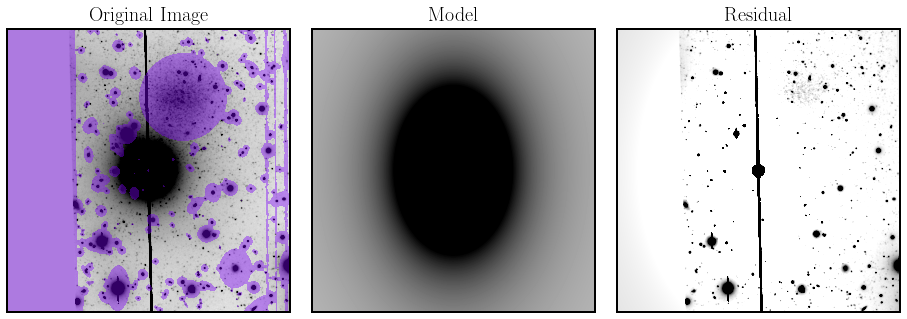

In [69]:
moffat_params = OrderedDict([
    ('PA', [100., 0., 360]),
    ('ell', [0.05, 0., 0.3]),
    ('I_0', [500, 0.01, 10000]),
    ('fwhm', [100, 0.01, 1000]),
    ('beta', [0.01, 0.0, 1.])
])

model = pymfit.Model(funcs = ['Moffat'], params = [moffat_params], centers = [[1100,1100]], dcent=40)
fitter = pymfit.PymFitter(model,save_files=True)
bestfit_fn = os.path.join(out_dir,'star_bestfit_r.txt')
config_fn = os.path.join(out_dir,'star_config_r.txt')

fitter.run(stack_fn_r.replace('_r.fits','_cutout_r.fits'), var_fn=os.path.join(out_dir,'flat_variance_image.fits'), mask_fn=os.path.join(out_dir,'star_mask.fits'), psf_fn=os.path.join(out_dir,'lbcr.median_psf_298.fits'), out_fn=bestfit_fn, outdir=out_dir, config_fn=config_fn, save_model=True, save_residual=True, will_viz=True)

fitter.viz_results(show=True, save_fn=os.path.join(out_dir,'star_modeling_results.png'), dpi=200);

In [70]:
fitter.results

OrderedDict([('comp_1',
              {'function': 'Moffat',
               'X0': 1098.8671,
               'Y0': 1102.6432,
               'X0_err': 0.0001,
               'Y0_err': 0.0001,
               'PA': 360.0,
               'PA_err': 0.0,
               'ell': 0.3,
               'ell_err': 0.0,
               'I_0': 10000.0,
               'I_0_err': 0.0,
               'fwhm': 231.449,
               'fwhm_err': 0.00013267,
               'beta': 1.0,
               'beta_err': 0.0}),
             ('reduced_chisq', 19782811.353568)])

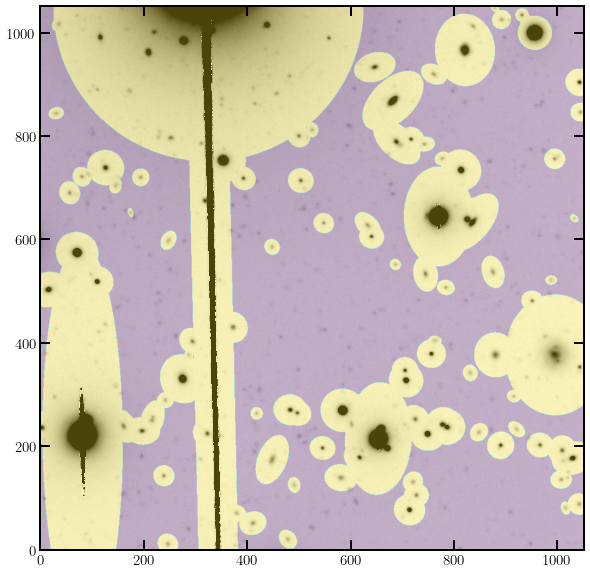

In [37]:
out_dir = '/Users/kirstencasey/real_image_tests/background_subtraction_tests/star_subtraction_tests'


cutout1_r = make_cutout(os.path.join(out_dir,'mean_stack_SEsky_background_r.fits'), (1477,1586), (1051,1051), ext = 0, cutout_fn=os.path.join(out_dir,'mean_stack_polynomial_background_cutout2_r.fits'))
vmin,vmax =  np.nanpercentile(cutout1_r.data, [.5, 98.])

mask_kws = dict(out_fn=os.path.join(out_dir,'cutout2_mask_r.fits'), thresh=12.0, kern_sig=1.0, backsize=15,
                        obj_rmin=200, grow_obj=12., use_hsc_mask=False, gal_pos=(1100,1100), seg_rmin=0.)
saturation_limit = 40000.
mask = pymfit.make_mask(os.path.join(out_dir,'mean_stack_polynomial_background_cutout2_r.fits'), **mask_kws)
mask[np.where(cutout1_r.data==0.)]=1

r_circ = 300
i_c, j_c = (1050,325)
ii, jj = np.mgrid[:mask.shape[0], :mask.shape[1]]
circ_mask = ((ii - i_c)**2 + (jj - j_c)**2) - r_circ**2 < 0
mask = mask.astype(bool) | circ_mask
mask = mask.astype(float)
'''
r_circ = 50
i_c, j_c = (600,0)
ii, jj = np.mgrid[:mask.shape[0], :mask.shape[1]]
circ_mask = ((ii - i_c)**2 + (jj - j_c)**2) - r_circ**2 < 0
mask = mask.astype(bool) | circ_mask
mask = mask.astype(float)

r_circ = 50
i_c, j_c = (995,955)
ii, jj = np.mgrid[:mask.shape[0], :mask.shape[1]]
circ_mask = ((ii - i_c)**2 + (jj - j_c)**2) - r_circ**2 < 0
mask = mask.astype(bool) | circ_mask
mask = mask.astype(float)
'''
plt.figure(figsize=(12,10))
plt.imshow(cutout1_r.data,vmin=vmin,vmax=vmax,cmap='gray_r',origin='lower')
plt.imshow(mask,origin='lower',alpha=0.3)

In [66]:
mask_hdu = fits.PrimaryHDU(mask)
mask_hdu.writeto(os.path.join(out_dir,'cutout1_mask_b.fits'),overwrite=True)

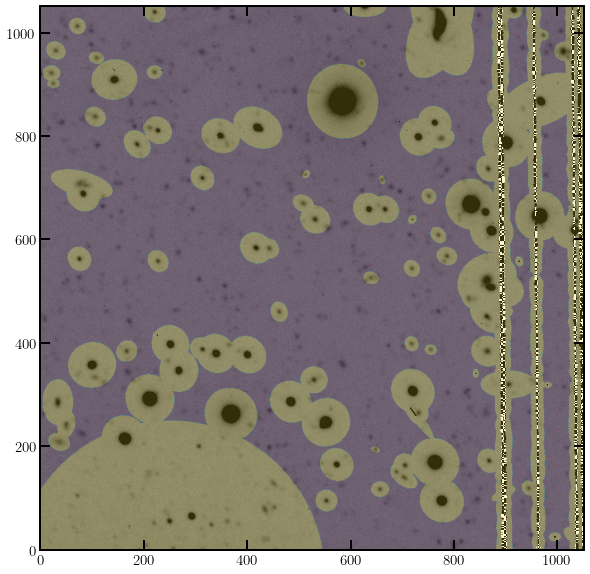

In [65]:
out_dir = '/Users/kirstencasey/real_image_tests/background_subtraction_tests/star_subtraction_tests'


cutout1_r = make_cutout(os.path.join(out_dir,'mean_stack_polynomial_background_b.fits'), (1815,3658), (1051,1051), ext = 0, cutout_fn=os.path.join(out_dir,'mean_stack_SEsky_background_cutout1_b.fits'))
vmin,vmax =  np.nanpercentile(cutout1_r.data, [.9, 98.])

mask_kws = dict(out_fn=os.path.join(out_dir,'cutout1_mask_b.fits'), thresh=8.0, kern_sig=1.0, backsize=15,
                        obj_rmin=200, grow_obj=12., use_hsc_mask=False, gal_pos=(1100,1100), seg_rmin=0.)
saturation_limit = 40000.
mask = pymfit.make_mask(os.path.join(out_dir,'mean_stack_SEsky_background_cutout1_b.fits'), **mask_kws)
mask[np.where(cutout1_r.data==0.)]=1

r_circ = 300
i_c, j_c = (-50,250)
ii, jj = np.mgrid[:mask.shape[0], :mask.shape[1]]
circ_mask = ((ii - i_c)**2 + (jj - j_c)**2) - r_circ**2 < 0
mask = mask.astype(bool) | circ_mask
mask = mask.astype(float)

plt.figure(figsize=(12,10))
plt.imshow(cutout1_r.data,vmin=vmin,vmax=vmax,cmap='gray_r',origin='lower')
plt.imshow(mask,origin='lower',alpha=0.2)